In [ ]:
!pip install git+https://github.com/mpicbg-csbd/stardist

In [ ]:
!unzip /content/sample_data/converted_grey.zip

In [ ]:
!unzip /content/sample_data/models.zip

## Import libraries

In [ ]:
# for main

import os
import sys
import numpy as np
import argparse
from argparse import RawTextHelpFormatter
from glob import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# pip
from stardist import random_label_cmap
from stardist import StarDist



# for predict

# pip
from csbdeep.utils import normalize
from stardist import dist_to_coord, non_maximum_suppression


# for centroid 
from sklearn.cluster import DBSCAN
from sklearn import metrics


# for export
import numpy as np



## Prediction module

In [ ]:
def stardist_predict(x, model, size, prob_thresh=0.5, coef_dist=0.5, nms_thresh=0.5):

    # Normalize images and fill small label holes
    axis_norm = (0, 1)  # normalize channels independently
    # axis_norm = (0, 1, 2)  # normalize channels jointly

    # normalized image
    img = normalize(x, 1, 99.8, axis=axis_norm)

    # Predict object probabilities and star-convex polygon distances
    prob, dist = model.predict(img)

    # Convert distances to polygon vertex coordinates
    coord = dist_to_coord(dist)

    # Perform non-maximum suppression for polygons above object probability threshold
    points = non_maximum_suppression(coord, prob, prob_thresh=prob_thresh, b=int(size*coef_dist), nms_thresh=nms_thresh)

    return coord, points


'''

   function to detect centroids of polygons, uses coord and point from StarDist prediction

    Arguments:
   -----------
       point: 1D array 
           x,y coordinates of the pixel (centroid)
        
        coord 4D array 
            xy coordinates for each of 32 vertexes associated with each point

   Returns:
   -----------
   float - surface area of the polygon.

   '''



def PolyArea(point, coord):
    x, y = coord[point[0], point[1], 1], coord[point[0], point[1], 0]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


##**Centroid module**

In [ ]:

'''

   function to cluster centroids of polygons based on proximity

    Arguments:
   -----------
       points: 1D array 
           x,y coordinates of the pixel (centroid)

        eps: float 
            distance to the nearest point
            
        min_samples: int
            minimum number of points to call a cluster

   Returns:
   -----------
   list - cluster labels for each centroid

   '''
def dbscan_alg(points, eps=15, min_samples=2):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    return labels


'''

   function to find medoid of a cluster

    Arguments:
   -----------
       cluster: int 
           cluster number currently analyzed

        points: list of arrays 
            coordinated of StarDist predicted centroids of polygons

        labels: list of int
            list of clusters for each centroids, predicted by DBSCAN

   Returns:
   -----------
   xy coordinates of polygon centroid which is medoid of a cluster 

   '''



def find_medoid(cluster, points, labels):
    rel_points = [points[x] for x in range(len(points)) if labels[x] == cluster]
    pwdist = metrics.pairwise_distances(rel_points)
    return rel_points[np.argmin(pwdist.sum(axis=1))]

## **Export module**

In [ ]:
'''

   function to crop image based on centroid coordinates

    Arguments:
   -----------
       img: 2D array 
           image as 2D array of pixels
           
        points: list
            list of xy coordinates of a centroid
        
        size: int
            size of a crop in pixels

   Returns:
   -----------
        2D array - cropped image

   '''


def slice_export(img, points, size):

    # detect top left corner of image
    start_coord = np.array(points)-int(size*0.5)

    # crop
    img_crop = img[start_coord[0]:start_coord[0]+size, start_coord[1]:start_coord[1]+size]

    return img_crop


In [ ]:
## Variables
wd="/content/converted_grey/"
rnd=True
rnd_numb=1
model='models'
out="/content/cropped/"
pt=1



## **Main function**

In [16]:
# import images
X_names = pd.DataFrame(sorted(glob(os.path.join(wd, '*.tif*'))))
X_names['base'] = X_names.loc[:,0].str.extract(r'(r\d+c\d+)')

# create output dir
if not os.path.exists(out):
  os.makedirs(out)

# random selection?
if rnd:
  X_names = X_names.groupby('base').apply(lambda x: x.sample(rnd_numb)).reset_index(drop=True)


X = [cv2.imread(x, -1) for x in X_names.loc[:,0]]

# import model
model = StarDist(None, name='stardist_no_shape_completion', basedir=model)

###### PREDICT FOR EACH IMAGE ######
for i in range(0, len(X)):
  coord, points = stardist_predict(X[i], model=model, size=72, prob_thresh=0.7, nms_thresh=0.7)

  # exclude points based on the polygon surface
  # estimate area
  area = [PolyArea(x, coord) for x in points]

  # perform filter by area
  points = [points[x] for x in range(len(points)) if area[x] > 100]

  # perform DBSCAN algorithm
  labels = dbscan_alg(points=points, eps=30, min_samples=2)

  # get individual points, which have no cluster
  points_filt = [points[x] for x in range(len(points)) if labels[x] == -1]

  # get medoid points for clusters
  point_clust = [find_medoid(x, points=points, labels=labels) for x in list(set(labels[labels != -1]))]

  # append both lists
  points_final = points_filt + point_clust

  # split and export single cells
  for j in range(0, len(points_final)):
    crop_img = slice_export(img = X[i], points=points_final[j], size = 70)

    # export
    cv2.imwrite(os.path.join(out, "_".join(['Pt{0:02d}'.format(pt),
                                                  X_names['base'][i],
                                                  '{0:04d}.tif'.format(j)])), crop_img)

Loading network weights from 'weights_best.h5'.


##**Optional example**

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


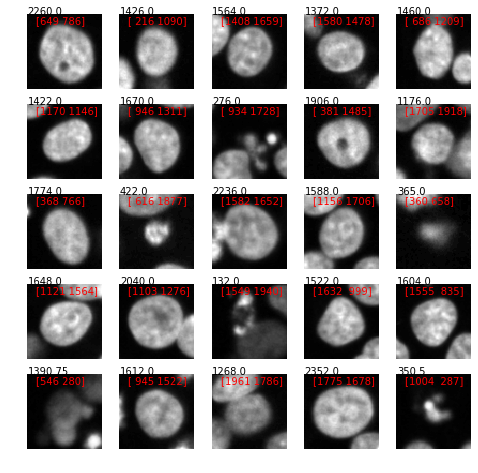

In [25]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
  p = points_final[np.random.choice(range(1, len(points_final)))]
  x, y = coord[p[0], p[1], 1], coord[p[0], p[1], 0]
  lol = PolyArea(p, coord)
  img_crop = slice_export(img=X[i], points=p, size=70)
  fig.add_subplot(rows, columns, k)
  plt.text(0, 0, s=lol)
  plt.text(8, 8, s=p, color='red')
  plt.imshow(img_crop, cmap='gray');
  plt.axis('off')
plt.savefig(fname=os.path.join(wd, "_".join(['Pt{0:02d}'.format(pt),
                                             X_names['base'][i],
                                             '{0:04d}_example.pdf'.format(j)])),
           transparent=True)